In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir drive/MyDrive/TreeData
!pip install -r yolov5/requirements.txt
!nvidia-smi


In [ ]:
!mv best.pt drive/MyDrive/TreeData/weights.pt

In [ ]:
import sys
sys.path.append('src/')

import TreeAnnotations
import NEONImageDataAndDownload
import MakeNeonYoloAppropriate
from pathlib import Path

In [ ]:
# Some globals
site = "YELL"
year = "2019"
year_month = "2019-07"

numberOfImagesToDownload = 12
train_proportion = 0.7
valid_proportion = 0.2
test_proportion = 0.1
maximumTotalCount = 5000

defaultCSVDropPath = Path("data/")

In [ ]:
# preliminary directory setup
MakeNeonYoloAppropriate.setup_yolo_directories()

In [ ]:
# get CSV data
TreeAnnotations.downloadAnnotation(site, f"{site.upper()}_{year}.csv")

In [ ]:
#download images
imageListEndpoint = NEONImageDataAndDownload.make_data_endpoint(site, year_month)
NEONImageDataAndDownload.download_n_images(imageListEndpoint, numberOfImagesToDownload, "./drive/MyDrive/TreeData")

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[3]:


import cv2
import glob
import random
from shutil import copyfile
from PIL import Image
from PIL import ImageDraw
import pandas as pd
import cv2
Image.MAX_IMAGE_PIXELS = None
import shutil
import os
import matplotlib.pyplot as plt
from pathlib import Path


In [ ]:
_UTM_UNITS  = 1000

def crop_satellite_refactored(imPath, dim_x1, dim_y1):
    """
    dim_x1 and dim_y1 define the dimensions of each cropped image
    """
    im = Image.open(imPath)
    dim_x0, dim_y0 = im.size
    num_x = int(dim_x0/dim_x1)
    num_y = int(dim_y0/dim_y1)
    
    for i in range(0,num_x):
        for j in range(0, num_y):
            x_begin = i*dim_x1
            x_end = x_begin + dim_x1
            y_begin = j*dim_y1
            y_end = y_begin + dim_y1
            cropped = im.crop((x_begin, y_begin, x_end, y_end))
            cropped.save(f"./drive/MyDrive/TreeData/tree_crop/images/{Path(imPath).stem}_{i}_{j}.jpg")

            #Create empty label files so that even empty plots are used in training
            with open(f"./drive/MyDrive/TreeData/tree_crop/images/{Path(imPath).stem}_{i}_{j}.txt", 'w') as fp:
                pass

def write_labels_refactored(csvFilePath, impath, geosite, dim_x0, dim_y0, dim_x1, dim_y1):
    dataframe = pd.read_csv(csvFilePath)
    filtered_dataframe = dataframe.loc[dataframe['geo_index'] == geosite]
    xoffset, yoffset = map(int, geosite.split("_"))

    for _, (left,right,top,bottom) in filtered_dataframe[["left", "right", "top", "bottom"]].iterrows():
        #Get UTM coordinates
        #UTM y coordinates are given assuming origin is bottom left
        #We must flip them as Image assumes origin is top left
        startx = left - xoffset
        stopx = right - xoffset
        starty = _UTM_UNITS - (bottom - yoffset)  #TODO:  why are we subtracting from UTM units, which is always 1000
        stopy = _UTM_UNITS - (top - yoffset) # I think we should be subtractin from the size of the image, which in this case is dim_y0
                                             # If so, also change yolov5Annotation

        #Convert to pixel coordinates
        p_startx = startx * (dim_x0/_UTM_UNITS)
        p_stopx = stopx * (dim_x0/_UTM_UNITS)
        
        p_starty = starty * (dim_y0/_UTM_UNITS)
        p_stopy = stopy * (dim_y0/_UTM_UNITS)
        
        num_x = int(dim_x0/dim_x1)
        num_y = int(dim_y0/dim_y1)
    
        #Find corresponding cropped image
        i_start = int(p_startx/dim_x1) #image with the left boumd
        i_stop = int(p_stopx/dim_x1) #image with the right bound
        
        j_start = int(p_starty/dim_y1)  
        j_stop = int(p_stopy/dim_y1)
       
        #Disregard trees that lie in the left over image resulting from dividing
        #image by new dimensions
        if(i_stop >= num_x or i_start >= num_x or j_stop >= num_y or j_start >= num_y):
            continue
    
        #Disregard trees along border of cropped images
        #These trees have bounding boxes crossing into more than one image
        if(i_start != i_stop or j_start != j_stop):
            continue

        #Move origin so that the pixel value is in reference to 0,0 of cropped image      
        crop_x_start = p_startx - (i_stop*dim_x1)
        crop_x_stop = p_stopx - (i_stop*dim_x1)
        crop_y_start = p_starty - (j_stop*dim_y1)
        crop_y_stop = p_stopy - (j_stop*dim_y1)

        #Standardized midpoints and width/height used for yolo labels
        s_width = (crop_x_stop-crop_x_start)/dim_x1
        s_height = (crop_y_start-crop_y_stop)/dim_x1
        s_x_mid = (crop_x_start+crop_x_stop)/(2*dim_x1)
        s_y_mid = (crop_y_start+crop_y_stop)/(2*dim_y1)
        
        #Verify that computations are correct by drawing bounding boxes
        #Do not run on final data
        #imPath = f'tree_crop/images/{Path(impath).stem}_{i_stop}_{j_stop}.jpg'
        #img = Image.open(imPath)
        #im_draw = ImageDraw.Draw(img)
        #im_draw.rectangle([crop_x_start, crop_y_stop, crop_x_stop, crop_y_start], width = 6, outline ="red")
        #img.save(imPath)
        
        fileName = f"./drive/MyDrive/TreeData/tree_crop/labels/{Path(impath).stem}_{i_stop}_{j_stop}.txt"
        txt = "0 {w_c:.8f} {h_c:.8f} {w:.8f} {h:.8f}\n"
        with open( fileName, 'a') as f:
            f.write(txt.format(w_c=s_x_mid, h_c=s_y_mid, w=s_width, h=s_height))
            #f.write(txt.format(w_c=p_startx, h_c=p_stopx, w=p_starty, h=p_stopy))



def select_train_valid_refactored(train, valid):
    processed_count = 0
    images = glob.glob("./drive/MyDrive/TreeData/tree_crop/images/*.jpg")
    random.Random(4).shuffle(images)
    
    #Parse training set
    for image in images:
        imagePath = Path(image)
        stem = imagePath.stem
        if (processed_count < train):
            train_valid_folder = "train"
        else:
            train_valid_folder = "valid"
        if(os.path.exists(f'./drive/MyDrive/TreeData/tree_crop/labels/{stem}.txt')):
            shutil.copy(imagePath, f'data/images/{train_valid_folder}/{imagePath.name}')
            shutil.copy(f'./drive/MyDrive/TreeData/tree_crop/labels/{stem}.txt', f'data/labels/{train_valid_folder}/{stem}.txt')
            processed_count = processed_count + 1
        if (processed_count == train + valid):
            break;

def run_inference(weights, im_size, conf_thresh):
    for imPath in glob.glob('yearly_sites/*.jpg'):
        !python ./yolov5/detect.py --source $imPath --weights $weights --img $im_size --conf $conf_thresh --save-txt --save-conf --max-det 40000

def get_tree_count():
    year_paths = glob.glob('yearly_sites/*.jpg')
    num_years = len(year_paths)
    years = []
    tree_count = []
    confidence = []
    for i in range(0, num_years):
        #exp folder is incremented like exp, exp2, exp3...
        if(i==0):
            exp = 'exp'
        else:
            exp = 'exp' + str(i+1)

        imPath = year_paths[i].split('.')[0].split('yearly_sites')[1]
        year = imPath.split('_')[0][1:]
        years.append(year)
    
        with open('./runs/detect/' + exp + '/labels/' + imPath + '.txt', 'r') as f:
            lines = f.readlines()
            tree_count.append(len(lines))
            confidence.append([])
            for line in lines:
                conf = float(line.split(' ')[-1].split('\n')[0])
                confidence[i].append(conf)
                
    return years, tree_count, confidence

def plot_tree_count(site, tree_count, years):
    plt.plot(years, tree_count)
    plt.title('Number of Trees')
    plt.ylabel('Trees')
    plt.xlabel('Years')
    plt.legend([site])
    plt.show()
    
def plot_confidence(site, confidence, years):
    for conf in confidence:
        plt.hist(conf, bins = 'auto')

    plt.title('Inference Confidence: ' + site)
    plt.xlabel('Confidence')
    plt.legend(years)
    plt.locator_params(axis='x', nbins=4)
    plt.show()

def get_yearly_sites(siteYear, geoIndex):    
  for s,Y in siteYear:
    endpoint = NEONImageDataAndDownload.make_data_endpoint(s, Y)
    downloadList = NEONImageDataAndDownload.getListOfSiteFilesForYear(endpoint)
    for entry in downloadList:
      if(geoIndex in entry['name']):
        NEONImageDataAndDownload.download_image(entry['name'], entry['url'], 'yearly_sites')

  trainPath = "./yearly_sites/"
  imageFileList = glob.glob(f'./yearly_sites/*{site.upper()}*.tif')
  for path in imageFileList:
    impath = Path(path)
    imRoot = impath.stem + ".jpg"
    MakeNeonYoloAppropriate.convert_tif_to_jpg(path, trainPath+imRoot)

In [ ]:
import glob
imageFileList = glob.glob(f'./drive/MyDrive/TreeData/*{site.upper()}*.tif')
for imFile in imageFileList:
  print(imFile)
  crop_satellite_refactored(imFile, 512,512)


./drive/MyDrive/TreeData/2019_YELL_2_535000_4971000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_541000_4981000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_534000_4976000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_533000_4975000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_526000_4977000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_535000_4979000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_540000_4978000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_532000_4981000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_536000_4975000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_538000_4977000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_535000_4968000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_546000_4977000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_530000_4974000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_543000_4972000_image.tif
./drive/MyDrive/TreeData/2019_YELL_2_546000_4973000_image.tif


In [ ]:
!mv ./YELL_2019.csv ./drive/MyDrive/TreeData/YELL_2019.csv

In [ ]:
#csvFilePath, impath, geosite, dim_x0, dim_y0, dim_x1, dim_y1
csvFilePath = Path("./drive/MyDrive/TreeData/YELL_2019.csv")
imageFileList = glob.glob(f'./drive/MyDrive/TreeData/*{site.upper()}*.tif')
for imFile in imageFileList:
  im = Image.open(imFile)
  dim_x0, dim_y0 = im.size
  pathParts = imFile.split('_')
  geoSite = f"{pathParts[3]}_{pathParts[4]}"
  write_labels_refactored(csvFilePath, imFile, geoSite, dim_x0, dim_y0,512,512)


In [ ]:
labelFileList = glob.glob(f'./drive/MyDrive/TreeData/tree_crop/labels/*.txt')
print(len(labelFileList))
train_count = int(0.8*len(labelFileList))
valid_count = int(0.2*len(labelFileList))

2502


In [ ]:
select_train_valid_refactored(train_count,valid_count)

In [ ]:
!source ./yolov5/weights/download_weights.sh

In [ ]:
!python ./yolov5/train.py --img 512 --batch 16 --epochs 300 --data ./data.yaml --cfg ./yolov5/models/yolov5m.yaml --weights "yolov5m.pt" --name tree_rgb --cache

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v5.0-145-ga1c3572 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=True, cfg='./yolov5/models/yolov5m.yaml', data='./data.yaml', device='', entity=None, epochs=300, evolve=False, exist_ok=False, global_rank=-1, hyp='./yolov5/data/hyp.scratch.yaml', image_weights=False, img_size=[512, 512], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='tree_rgb', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/tree_rgb', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, weights='yolov5m.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', vie

In [ ]:
trainPath = "./drive/MyDrive/TreeData/"
imageFileList = glob.glob(f'./drive/MyDrive/TreeData/*{site.upper()}*.tif')
from pathlib import Path
for path in imageFileList:
    impath = Path(path)
    imRoot = impath.stem + ".jpg"
    print(imRoot)
    MakeNeonYoloAppropriate.convert_tif_to_jpg(path, trainPath+imRoot)



In [ ]:
!python ./yolov5/detect.py --source ./data/images/valid --weights ./runs/train/tree_rgb2/weights/best.pt --img 512 --conf 0.05

In [ ]:
!zip -r epoch300_b16_482im.zip ./runs/train/tree_rgb/

In [ ]:
#Download several years at one geo index
siteYear = [('YELL', '2018-07'), ('YELL', '2019-07'), ('YELL', '2020-07')]
geoIndex = '541000_4977000'
get_yearly_sites(siteYear, geoIndex)

In [ ]:
#Run inference on images in yearly_sites
run_inference('best_small.pt', 10000, 0.2)

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.2, device='', exist_ok=False, half=False, hide_conf=False, hide_labels=False, img_size=10000, iou_thres=0.45, line_thickness=3, max_det=1000, name='exp', nosave=False, project='runs/detect', save_conf=True, save_crop=False, save_txt=True, source='yearly_sites/2019_YELL_2_541000_4977000_image.jpg', update=False, view_img=False, weights=['best_small.pt'])
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v5.0-145-ga1c3572 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 308 layers, 21037638 parameters, 0 gradients, 50.3 GFLOPs
tcmalloc: large alloc 1203847168 bytes == 0x56171e92c000 @  0x7fd38e398b6b 0x7fd38e3b8379 0x7fd323b7825e 0x7fd323b799d2 0x7fd36085c8e6 0x7fd360cbedd9 0x7fd3611c977a 0x7fd361194ef9 0x7fd36114b657 0x7fd360fef929 0x7fd360cc290c 0x7fd3612d0209 0x7fd3612d048a 0x7fd3611a4239 0x7fd36115831e 0x7fd36102b4fb 0x7fd3723e1823 0x561687c4acc0 0x561687c4

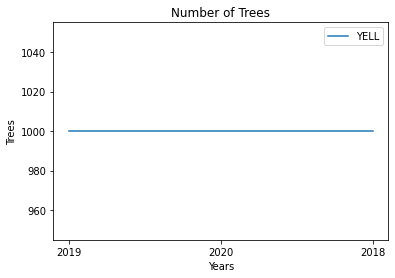

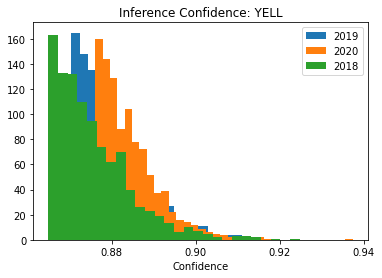

In [ ]:
#Plot Conifdence and Tree Count
years, tree_count, confidence = get_tree_count()

plot_tree_count(site, tree_count, years)
plot_confidence(site, confidence, years)

In [ ]:
!rm -r runs/detect

In [ ]:
!rm -r drive/MyDrive/TreeData/tree_crop